In [18]:
import zipfile
zip_ref = zipfile.ZipFile(r"C:\Users\671473\Documents\SuperAI_5\L1\hearth-disease-recognition.zip","r")
zip_ref.extractall()
zip_ref.close()

In [19]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns 

#preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler,OneHotEncoder,LabelEncoder

# LV0
from sklearn.ensemble import RandomForestClassifier                     #1
from sklearn.svm import SVC                                             #2
from sklearn.neighbors import KNeighborsClassifier                      #3
from xgboost import XGBClassifier, plot_importance                      #4
#LV 1
from sklearn.linear_model import LogisticRegression  
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import RandomizedSearchCV

In [20]:
train = pd.read_csv(r'C:\Users\671473\Documents\Training\kaggle competitions\titanic\titanic\train.csv')

In [5]:
train.columns.tolist()

['History of HeartDisease or Attack',
 'High Blood Pressure',
 'Told High Cholesterol',
 'Cholesterol Checked',
 'Body Mass Index',
 'Smoked 100+ Cigarettes',
 'Diagnosed Stroke',
 'Diagnosed Diabetes',
 'Leisure Physical Activity',
 'Heavy Alcohol Consumption',
 'Health Care Coverage',
 'Doctor Visit Cost Barrier',
 'General Health',
 'Difficulty Walking',
 'Sex',
 'Education Level',
 'Income Level',
 'Age',
 'Vegetable or Fruit Intake (1+ per Day)']

In [ ]:
train.info()

In [ ]:
train.nunique()

Ans in Y/N

In [64]:
category_counts = train.groupby('History of HeartDisease or Attack').size().reset_index(name='Count')
print(category_counts)

  History of HeartDisease or Attack   Count
0                                No  203322
1                               Yes   18068


Data Preprocessing

In [21]:
train.drop(columns=['ID'],inplace=True)

In [22]:
train.drop(columns=['Education Level','Income Level'],inplace=True)

In [23]:
train["History of HeartDisease or Attack"] = train["History of HeartDisease or Attack"].replace("NaN", np.nan)
train = train.dropna(subset=["History of HeartDisease or Attack"])

In [24]:
num_features = train.select_dtypes(include=[np.number]).columns.tolist()
train[num_features] = train[num_features].fillna(train[num_features].mean())

# num_features.fillna(num_features.mean(),inplace=True)                    >>For DF

scaler = StandardScaler()
num_scaled = pd.DataFrame(scaler.fit_transform(train[num_features]), columns=num_features)

In [25]:
le = LabelEncoder()
train["History of HeartDisease or Attack"] = le.fit_transform(train["History of HeartDisease or Attack"])
# df['Extracurricular Activities'] = df['Extracurricular Activities'].map({'Yes': 1, 'No': 0}) 

In [ ]:
train.hist(bins=30,figsize=(15,10))    
plt.show()

In [ ]:
correlation_matrix = train.select_dtypes(include=np.number).corr()
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix,annot=True,cmap='coolwarm')

In [ ]:
sns.pairplot(train.select_dtypes(include=np.number))

In [26]:
cat_features= train.select_dtypes(include=['object']).columns.tolist()
encoded_cat_features = pd.get_dummies(train[cat_features], drop_first=False)

In [12]:
# print(f"num_scaled rows: {num_scaled.shape[0]}")
# print(f"encoded_cat_features rows: {encoded_cat_features.shape[0]}")
# print(f"train rows: {train.shape[0]}")
# print(f"final_X rows: {final_X.shape[0]}")
# print(f"y rows: {y.shape[0]}")


num_scaled rows: 221390
encoded_cat_features rows: 221390
train rows: 221390
final_X rows: 223076


In [27]:
num_scaled = num_scaled.reset_index(drop=True)
encoded_cat_features = encoded_cat_features.reset_index(drop=True)

final_X = pd.concat([num_scaled, encoded_cat_features], axis=1)

x = final_X.values 
y = train["History of HeartDisease or Attack"].values


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y,random_state=42)


In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, precision_score, balanced_accuracy_score
from sklearn.metrics import recall_score, f1_score,fbeta_score

In [59]:
from sklearn.metrics import make_scorer, fbeta_score
f2_scorer = make_scorer(fbeta_score, beta=2)

In [30]:
def evaluate_model(name, model, y_pred, x_train, y_train, y_test, le):
    decoded_y_test = le.inverse_transform(y_test)
    decoded_y_pred = le.inverse_transform(y_pred)

    cfmx = confusion_matrix(decoded_y_test, decoded_y_pred, labels=le.classes_)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cfmx, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, 
                yticklabels=le.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()

    print(f"Classification Report for {name}:\n")
    print('Model Training Score', '{:.2f}'.format(model.score(x_train, y_train)))
    
    try:
        accuracy = accuracy_score(decoded_y_test, decoded_y_pred)
        balanced_accuracy = balanced_accuracy_score(decoded_y_test, decoded_y_pred)
        precision = precision_score(decoded_y_test, decoded_y_pred, average='weighted')
        recall = recall_score(decoded_y_test, decoded_y_pred, average='weighted')
        f1 = f1_score(decoded_y_test, decoded_y_pred, average='weighted')
        f2 = fbeta_score(decoded_y_test, decoded_y_pred, average='weighted', beta=2)  # F2 score
        
        print(f'Accuracy: {accuracy:.2f}')
        print(f'Balanced Accuracy: {balanced_accuracy:.2f}')
        print(f'Precision (weighted): {precision:.2f}')
        print(f'Recall (weighted): {recall:.2f}')
        print(f'F1 Score (weighted): {f1:.2f}')
        print(f'F2 Score (weighted): {f2:.2f}') 
    except ValueError as e:
        print(f"Error in metrics calculation for {name}: {e}")

    try:
        target_names = [str(label) for label in le.classes_]
        print(classification_report(decoded_y_test, decoded_y_pred, target_names=target_names))
    except ValueError as e:
        print(f"Error in classification_report for {name}: {e}")
    
    print("-" * 50)

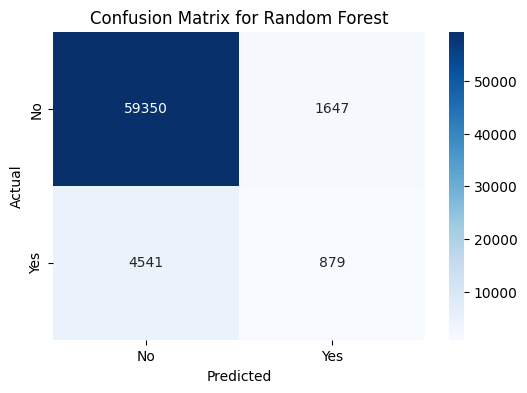

Classification Report for Random Forest:

Model Training Score 1.00
Accuracy: 0.91
Balanced Accuracy: 0.57
Precision (weighted): 0.88
Recall (weighted): 0.91
F1 Score (weighted): 0.89
F2 Score (weighted): 0.90
              precision    recall  f1-score   support

          No       0.93      0.97      0.95     60997
         Yes       0.35      0.16      0.22      5420

    accuracy                           0.91     66417
   macro avg       0.64      0.57      0.59     66417
weighted avg       0.88      0.91      0.89     66417

--------------------------------------------------


In [36]:
# Random Forest Model
rf_model = RandomForestClassifier(n_estimators=50, random_state=42,class_weight='balanced')
rf_model.fit(x_train, y_train)
y_pred_rf = rf_model.predict(x_test)

evaluate_model("Random Forest", rf_model, y_pred_rf, x_train, y_train, y_test, le)

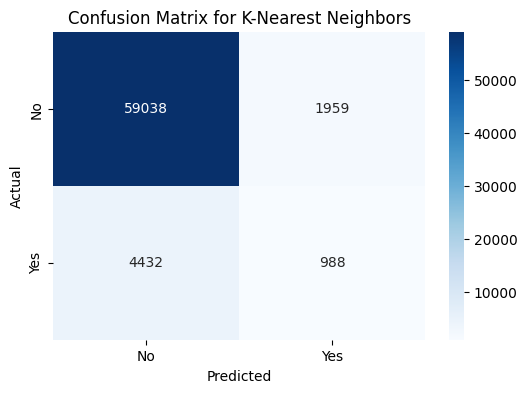

Classification Report for K-Nearest Neighbors:

Model Training Score 1.00
Accuracy: 0.90
Balanced Accuracy: 0.58
Precision (weighted): 0.88
Recall (weighted): 0.90
F1 Score (weighted): 0.89
F2 Score (weighted): 0.90
              precision    recall  f1-score   support

          No       0.93      0.97      0.95     60997
         Yes       0.34      0.18      0.24      5420

    accuracy                           0.90     66417
   macro avg       0.63      0.58      0.59     66417
weighted avg       0.88      0.90      0.89     66417

--------------------------------------------------


In [38]:
# K-Nearest Neighbors Model
knn_model = KNeighborsClassifier(n_neighbors=5,weights='distance')
knn_model.fit(x_train, y_train)
y_pred_knn = knn_model.predict(x_test)

evaluate_model("K-Nearest Neighbors", knn_model, y_pred_knn, x_train, y_train, y_test, le)

c:\Users\671473\py_virtualenv\vs\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:14:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


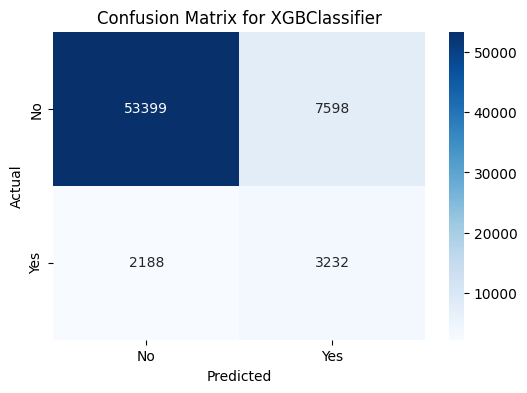

Classification Report for XGBClassifier:

Model Training Score 0.87
Accuracy: 0.85
Balanced Accuracy: 0.74
Precision (weighted): 0.91
Recall (weighted): 0.85
F1 Score (weighted): 0.87
F2 Score (weighted): 0.86
              precision    recall  f1-score   support

          No       0.96      0.88      0.92     60997
         Yes       0.30      0.60      0.40      5420

    accuracy                           0.85     66417
   macro avg       0.63      0.74      0.66     66417
weighted avg       0.91      0.85      0.87     66417

--------------------------------------------------


In [45]:
# XGB Model
xgb_model = XGBClassifier(use_label_encoder=False,scale_pos_weight=5,random_state=42)
xgb_model.fit(x_train, y_train)
y_pred_xgb = xgb_model.predict(x_test)

evaluate_model("XGBClassifier", xgb_model, y_pred_xgb, x_train, y_train, y_test, le)

In [67]:
def evaluate_model_with_random_search(name, model, param_grid, x_train, y_train, x_test, y_test, le, resample=False):
    print(f"Running RandomizedSearchCV for {name}...\n")
    
    rand_search = RandomizedSearchCV(
        estimator=model, 
        param_distributions=param_grid,
        scoring=f2_scorer, 
        cv=5, 
        n_iter=50,  #
        verbose=1, 
        n_jobs=-1,  
        random_state=42
    )
    
    rand_search.fit(x_train, y_train)  

    best_model = rand_search.best_estimator_
    y_pred = best_model.predict(x_test)
    
    decoded_y_test = le.inverse_transform(y_test)
    decoded_y_pred = le.inverse_transform(y_pred)
    
    print(f"Best Parameters for {name}: {rand_search.best_params_}")
    print(f"Best CV F2 Score for {name}: {rand_search.best_score_:.4f}")
    
    print(f"\nClassification Report for {name}:\n")
    print(classification_report(decoded_y_test, decoded_y_pred, target_names=le.classes_))
    print("-" * 50)

In [50]:
# Subsampling 
sample_size = 0.2
x_train_sampled, _, y_train_sampled, _ = train_test_split(x_train, y_train, train_size=sample_size, random_state=42)

In [68]:
# Hyperparameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [10, 50, 100, 200, 500],
    'max_depth': [None, 5, 10, 15, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['gini', 'entropy']
}
evaluate_model_with_random_search(
    'Random Forest', 
    RandomForestClassifier(random_state=0), 
    param_grid_rf,
    x_train_sampled, y_train_sampled, x_test, y_test, le, resample=False
)

Running RandomizedSearchCV for Random Forest...

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters for Random Forest: {'n_estimators': 10, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': None, 'criterion': 'gini'}
Best CV F2 Score for Random Forest: 0.1573

Classification Report for Random Forest:

              precision    recall  f1-score   support

          No       0.93      0.98      0.95     60997
         Yes       0.40      0.14      0.21      5420

    accuracy                           0.91     66417
   macro avg       0.66      0.56      0.58     66417
weighted avg       0.88      0.91      0.89     66417

--------------------------------------------------


In [69]:

param_grid_knn = {
    'n_neighbors': list(range(2, 21)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}
evaluate_model_with_random_search(
    'KNN', 
    KNeighborsClassifier(), 
    param_grid_knn,
    x_train_sampled, y_train_sampled, x_test, y_test, le, resample=False
)

Running RandomizedSearchCV for KNN...

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters for KNN: {'weights': 'distance', 'n_neighbors': 2, 'metric': 'manhattan'}
Best CV F2 Score for KNN: 0.2297

Classification Report for KNN:

              precision    recall  f1-score   support

          No       0.93      0.94      0.93     60997
         Yes       0.25      0.24      0.24      5420

    accuracy                           0.88     66417
   macro avg       0.59      0.59      0.59     66417
weighted avg       0.88      0.88      0.88     66417

--------------------------------------------------


In [73]:
# Hyperparameter grid for XGB
param_grid_xgb = {
    'n_estimators': [100, 200, 500],
    'learning_rate': np.logspace(-3, 0, 10).tolist(),
    'max_depth': [3, 5, 7, 10, 15],
    'subsample': np.linspace(0.5, 1.0, 5).tolist(),
    'colsample_bytree': np.linspace(0.5, 1.0, 5).tolist(),
    'min_child_weight': [1, 3, 5, 7, 9],
    'reg_alpha': np.logspace(-2, 1, 5).tolist(),
    'reg_lambda': np.logspace(-2, 1, 5).tolist(),
    'gamma': np.logspace(-2, 1, 5).tolist(),
    'scale_pos_weight':list(range(0, 10))
}

evaluate_model_with_random_search(
    'XGB', 
    XGBClassifier(random_state=0), 
    param_grid_xgb,
    x_train_sampled, y_train_sampled, x_test, y_test, le, resample=False
)

Running RandomizedSearchCV for XGB...

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters for XGB: {'subsample': 0.5, 'scale_pos_weight': 8, 'reg_lambda': 10.0, 'reg_alpha': 10.0, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0.05623413251903491, 'colsample_bytree': 0.75}
Best CV F2 Score for XGB: 0.5205

Classification Report for XGB:

              precision    recall  f1-score   support

          No       0.97      0.81      0.89     60997
         Yes       0.26      0.73      0.38      5420

    accuracy                           0.81     66417
   macro avg       0.61      0.77      0.63     66417
weighted avg       0.91      0.81      0.84     66417

--------------------------------------------------


In [80]:
from imblearn.under_sampling import RandomUnderSampler

undersampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = undersampler.fit_resample(x_train, y_train)






Opti Model

[0]	validation_0-logloss:0.56326	validation_0-auc:0.83633
[1]	validation_0-logloss:0.56066	validation_0-auc:0.84413
[2]	validation_0-logloss:0.55809	validation_0-auc:0.84572
[3]	validation_0-logloss:0.55559	validation_0-auc:0.84601


c:\Users\671473\py_virtualenv\vs\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:24:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[4]	validation_0-logloss:0.55302	validation_0-auc:0.84756
[5]	validation_0-logloss:0.55060	validation_0-auc:0.84913
[6]	validation_0-logloss:0.54816	validation_0-auc:0.84952
[7]	validation_0-logloss:0.54600	validation_0-auc:0.85058
[8]	validation_0-logloss:0.54366	validation_0-auc:0.85055
[9]	validation_0-logloss:0.54164	validation_0-auc:0.85106
[10]	validation_0-logloss:0.53945	validation_0-auc:0.85099
[11]	validation_0-logloss:0.53735	validation_0-auc:0.85151
[12]	validation_0-logloss:0.53526	validation_0-auc:0.85177
[13]	validation_0-logloss:0.53319	validation_0-auc:0.85165
[14]	validation_0-logloss:0.53109	validation_0-auc:0.85227
[15]	validation_0-logloss:0.52896	validation_0-auc:0.85236
[16]	validation_0-logloss:0.52694	validation_0-auc:0.85236
[17]	validation_0-logloss:0.52483	validation_0-auc:0.85236
[18]	validation_0-logloss:0.52314	validation_0-auc:0.85261
[19]	validation_0-logloss:0.52119	validation_0-auc:0.85262
[20]	validation_0-logloss:0.51933	validation_0-auc:0.85258
[21

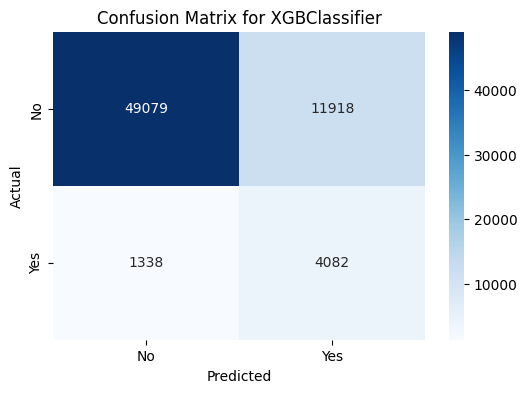

Classification Report for XGBClassifier:

Model Training Score 0.81
Accuracy: 0.80
Balanced Accuracy: 0.78
Precision (weighted): 0.91
Recall (weighted): 0.80
F1 Score (weighted): 0.84
F2 Score (weighted): 0.81
              precision    recall  f1-score   support

          No       0.97      0.80      0.88     60997
         Yes       0.26      0.75      0.38      5420

    accuracy                           0.80     66417
   macro avg       0.61      0.78      0.63     66417
weighted avg       0.91      0.80      0.84     66417

--------------------------------------------------


In [98]:
# XGB Model Opti

xgb_model_opti = XGBClassifier(use_label_encoder=False,
                               booster="dart",
                               scale_pos_weight=8,
                               random_state=42,subsample = 0.5,
                               reg_lambda = 10.0,reg_alpha = 10.0,
                               n_estimators= 1000,
                               min_child_weight= 5,
                               max_depth =7,
                               learning_rate = 0.01,
                               gamma = 0.056,
                               colsample_bytree = 0.75,
                               eval_metric=["logloss", "auc"],
                               early_stopping_rounds= 50
                               )
xgb_model_opti.fit(x_train, y_train,
                   eval_set=[(x_test, y_test)],  # Validate on test set
                   verbose=True)
# xgb_model_opti.fit(X_train_under, y_train_under)
y_pred_xgb_opti = xgb_model_opti.predict(x_test)

# Evaluate and display results for XGB
evaluate_model("XGBClassifier", xgb_model_opti, y_pred_xgb_opti, x_train, y_train, y_test, le)

In [104]:
best_iteration = xgb_model_opti.best_iteration
print(f"Best iteration: {best_iteration}")

Best iteration: 576


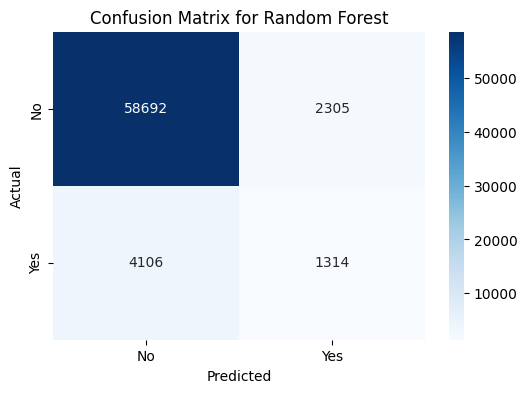

Classification Report for Random Forest:

Model Training Score 0.99
Accuracy: 0.90
Balanced Accuracy: 0.60
Precision (weighted): 0.89
Recall (weighted): 0.90
F1 Score (weighted): 0.89
F2 Score (weighted): 0.90
              precision    recall  f1-score   support

          No       0.93      0.96      0.95     60997
         Yes       0.36      0.24      0.29      5420

    accuracy                           0.90     66417
   macro avg       0.65      0.60      0.62     66417
weighted avg       0.89      0.90      0.89     66417

--------------------------------------------------


In [99]:

# Random Forest Model
rf_model_opti = RandomForestClassifier(n_estimators=200, random_state=42,
                                       class_weight='balanced',
                                       min_samples_split=2,
                                       min_samples_leaf=2,
                                       max_features=None,
                                       max_depth=None,
                                       criterion='gini')
rf_model_opti.fit(x_train, y_train)
y_pred_rf_opti = rf_model_opti.predict(x_test)
# Evaluate and display results for Random Forest
evaluate_model("Random Forest", rf_model_opti, y_pred_rf_opti, x_train, y_train, y_test, le)


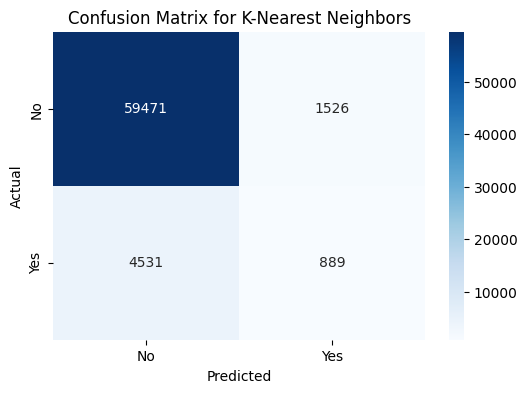

Classification Report for K-Nearest Neighbors:

Model Training Score 1.00
Accuracy: 0.91
Balanced Accuracy: 0.57
Precision (weighted): 0.88
Recall (weighted): 0.91
F1 Score (weighted): 0.89
F2 Score (weighted): 0.90
              precision    recall  f1-score   support

          No       0.93      0.97      0.95     60997
         Yes       0.37      0.16      0.23      5420

    accuracy                           0.91     66417
   macro avg       0.65      0.57      0.59     66417
weighted avg       0.88      0.91      0.89     66417

--------------------------------------------------


In [100]:
# K-Nearest Neighbors Model
knn_model_opti = KNeighborsClassifier(n_neighbors=8,weights='distance',metric='manhattan')
knn_model_opti.fit(x_train, y_train)
y_pred_knn_opti = knn_model_opti.predict(x_test)
# Evaluate and display results for KNN
evaluate_model("K-Nearest Neighbors", knn_model_opti, y_pred_knn_opti, x_train, y_train, y_test, le)

In [101]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
xgb_model_best = XGBClassifier(
    use_label_encoder=False,
    booster="dart",
    scale_pos_weight=8,
    random_state=42,
    subsample=0.5,
    reg_lambda=10.0,
    reg_alpha=10.0,
    n_estimators=best_iteration,
    min_child_weight=5,
    max_depth=7,
    learning_rate=0.01,
    gamma=0.056,
    colsample_bytree=0.75
)
xgb_model_best.fit(x_train, y_train)


c:\Users\671473\py_virtualenv\vs\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:23:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\671473\py_virtualenv\vs\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:30:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\671473\py_virtualenv\vs\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:37:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\671473\py_

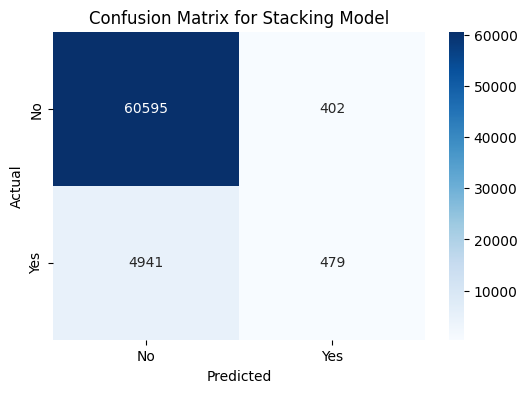

Classification Report for Stacking Model:

Model Training Score 0.93
Accuracy: 0.92
Balanced Accuracy: 0.54
Precision (weighted): 0.89
Recall (weighted): 0.92
F1 Score (weighted): 0.89
F2 Score (weighted): 0.91
              precision    recall  f1-score   support

          No       0.92      0.99      0.96     60997
         Yes       0.54      0.09      0.15      5420

    accuracy                           0.92     66417
   macro avg       0.73      0.54      0.55     66417
weighted avg       0.89      0.92      0.89     66417

--------------------------------------------------


In [113]:
stacked_model = StackingClassifier(
    estimators=[
        ('xgb', XGBClassifier(
    use_label_encoder=False,
    booster="dart",
    scale_pos_weight=8,
    random_state=42,
    subsample=0.5,
    reg_lambda=10.0,
    reg_alpha=10.0,
    n_estimators=best_iteration,  # ✅ Use the best iteration
    min_child_weight=5,
    max_depth=7,
    learning_rate=0.01,
    gamma=0.056,
    colsample_bytree=0.75)),
        ('rf', rf_model_opti ),
        # ('knn',knn_model_opti)
    ],
    final_estimator=XGBClassifier(n_estimators=100, max_depth=3)
)

stacked_model.fit(x_train_sampled, y_train_sampled)
y_pred_stacked = stacked_model.predict(x_test)

evaluate_model("Stacking Model", stacked_model, y_pred_stacked, x_train_sampled, y_train_sampled, y_test, le)


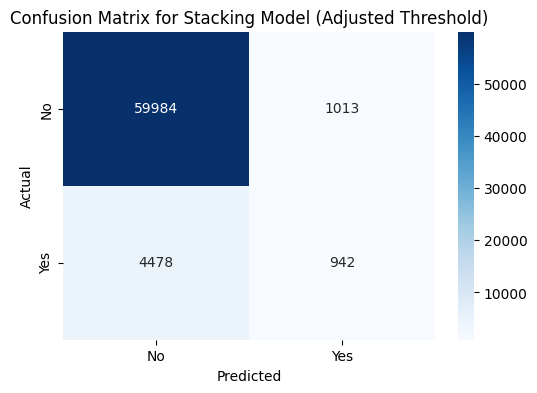

Classification Report for Stacking Model (Adjusted Threshold):

Model Training Score 0.92
Accuracy: 0.92
Balanced Accuracy: 0.58
Precision (weighted): 0.89
Recall (weighted): 0.92
F1 Score (weighted): 0.90
F2 Score (weighted): 0.91
              precision    recall  f1-score   support

          No       0.93      0.98      0.96     60997
         Yes       0.48      0.17      0.26      5420

    accuracy                           0.92     66417
   macro avg       0.71      0.58      0.61     66417
weighted avg       0.89      0.92      0.90     66417

--------------------------------------------------


In [114]:
y_pred_proba = stacked_model.predict_proba(x_test)[:, 1]  # Probability of positive class
threshold = 0.4  # Lower threshold to reduce FN
y_pred_adjusted = (y_pred_proba > threshold).astype(int)

evaluate_model("Stacking Model (Adjusted Threshold)", stacked_model, y_pred_adjusted, x_train, y_train, y_test, le)


In [ ]:
# from sklearn.ensemble import VotingClassifier

# voting_model = VotingClassifier(
#     estimators=[
#         ('xgb', xgb_model_opti),
#         ('rf', rf_model_opti),
#     ],
#     voting='hard'  # Majority voting
# )

# voting_model.fit(x_train, y_train)
# y_pred_voting = voting_model.predict(x_test)

# evaluate_model("Voting Classifier (Hard Voting)", voting_model, y_pred_voting, x_train, y_train, y_test, le)


In [ ]:
# voting_model = VotingClassifier(
#     estimators=[
#         ('xgb', xgb_model_opti),
#         ('rf', rf_model_opti),
#     ],
#     voting='soft'  # Uses predicted probabilities
# )

# voting_model.fit(x_train, y_train)
# y_pred_voting = voting_model.predict(x_test)

# evaluate_model("Voting Classifier (Soft Voting)", voting_model, y_pred_voting, x_train, y_train, y_test, le)


Prediction

In [47]:
test = pd.read_csv(r"C:\Users\671473\Documents\Training\kaggle competitions\titanic\titanic\test.csv")

In [52]:
id_column = test['ID']
test = test.drop(['ID','Education Level','Income Level'], axis=1)

In [56]:
# num_features_test = test.select_dtypes(include=[np.number]).columns.tolist()
test[num_features] = test[num_features].fillna(test[num_features].mean())

# num_features.fillna(num_features.mean(),inplace=True)                    >>For DF

num_scaled_test = pd.DataFrame(scaler.transform(test[num_features]), columns=num_features)
encoded_cat_features_test = pd.get_dummies(test[cat_features], drop_first=False)
# le = LabelEncoder()
# train["History of HeartDisease or Attack"] = le.fit_transform(train["History of HeartDisease or Attack"])

In [109]:
X_new = pd.concat([num_scaled_test, encoded_cat_features_test], axis=1)

x_new = X_new.values 
y_pred_test = xgb_model_opti.predict(x_new)
predictions = le.inverse_transform(y_pred_test)

results = pd.DataFrame({
    'ID': id_column,
    'History of HeartDisease or Attack': predictions
})

In [71]:
results 

,ID,History of HeartDisease or Attack
0,test_000001,No
1,test_000002,No
2,test_000003,No
3,test_000004,No
4,test_000005,No
...,...,...
74356,test_074357,No
74357,test_074358,No
74358,test_074359,Yes
74359,test_074360,Yes


In [110]:
results.to_csv(r"\2_XGB.csv", index=False)